# Lab: Geofencing to Organize Your Geospatial Data with BigQuery GIS
In this lab you will group geospatial data based on their geographic attributes in BigQuery GIS using Python and Jupyter notebooks.

[BigQuery](https://cloud.google.com/bigquery/docs) is a serverless data warehouse solution on Google Cloud Platform (GCP) that allows users to interact with their data using standard ANSI SQL.

Using the BigQuery Python API, BigQuery databases can be directly accessed via Python and/or Jupyter notebooks.

BigQuery GIS allows point, line or polygon geospatial data to be stored as a special `GEOGRAPHY` data type within a BigQuery table.  This `GEOGRAPHY` datatype is stored as a [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) object. 

## Getting Started
In order to connect to BigQuery in Python, you need to install the BigQuery Python client library and the BigQuery Storage API.  You will also need to set up the notebook to use the "magic" command, which we will be using to access BigQuery throughout this lab.  

In addition, you will need to install the `pandas` package if you don't have it already installed.

Note: If you are running this notebook in a GCP environment, these packages should be pre-installed.

In [ ]:
%pip install 'google-cloud-bigquery'
%pip install 'google-cloud-bigquery-storage'
%pip install 'pyarrow'
%pip install 'pandas'

%load_ext google.cloud.bigquery

## Spatial Joins
For this lab, we are going to use *predicate* functions, which can also be called *Spatial Joins*.  This class of functions determines the relationship between two or more `GEOGRAPHY` objects (e.g., if one object is containd within another object).  The predicate function returns a value of TRUE if the relationship exists and FALSE otherwise.  Since these functions create a logical vector, they are often used in the WHERE clause of a SQL statement.  

## Counting Crimes in Chicago
Let's use the [ST_CONTAINS](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_contains) function to determine how many crimes were committed by zip code each year in Chicago.  The `ST_CONTAINS` function takes two arguments and returns TRUE if no point of the second `GEOGRAPHY` argument is outside the first `GEOGRAPHY` argument, and the interiors intersect.  The function returns FALSE otherwise. 

We can do this by combining two datasets from Google's [public datasets](https://cloud.google.com/public-datasets) available within BigQuery:
* The "zip_codes" table from the "geo_us_boundaries" dataset
* The "crime" table from the "chicago_crime" dataset.

For this query, the first argument to the `ST_CONTAINS` function will be the column of `GEOGRAPHY` polygons that represent each zip code.  The second argument to the `ST_CONTAINS` function will be a column of `GEOGRAPHY` points that represent the location of each crime.

We can directly write ANSI SQL to query BigQuery tables by using the `%%bigquery` [magic command](https://googleapis.dev/python/bigquery/latest/magics.html).

In [1]:
%%bigquery
SELECT year, zip_code, count(*) crime_count
FROM 
`bigquery-public-data.chicago_crime.crime` crime,
`bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
WHERE ST_CONTAINS(zip_codes.zip_code_geom, ST_GEOGPOINT(crime.longitude, crime.latitude))
GROUP BY year, zip_code
ORDER BY year desc, crime_count desc;

,year,zip_code,crime_count
0,2020,60620,7794
1,2020,60628,7615
2,2020,60624,7234
3,2020,60619,7205
4,2020,60623,6743
...,...,...,...
1608,2001,60453,1
1609,2001,60459,1
1610,2001,60803,1
1611,2001,60076,1


Notice that the "crime" table does not have a native `GEOGRAPHY` field, so we need to create one using the [ST_GEOGPOINT](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_geogpoint) constructor function from the latitude/longitude coordinate values.  The "zip_code_geom" field in the "zip_codes" table is already of type `GEOMETRY` so no conversion is necessary.

**Try It:**  
How has the number of crimes changed for zip code 60629 in a five year range from 2015 through 2019??  
*Hint:* Try adding additional restrictions to the WHERE clause.

In [ ]:
%%bigquery
SELECT year, zip_code, count(*) crime_count
FROM 
`bigquery-public-data.chicago_crime.crime` crime,
`bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
WHERE ST_CONTAINS(??, ??)
and ??
GROUP BY year, zip_code
ORDER BY year desc, crime_count desc;

## Mapping Chicago Crimes
We can now use the [geopandas](https://geopandas.org) package to map the number of crimes in each postal code.  

First, we need to create a [geopandas DataFrame](https://geopandas.org/data_structures.html#geodataframe), which is a subclass of a [pandas](https://pandas.pydata.org) DataFrame where one field, the "geometry" field, is a [GeoSeries](https://geopandas.org/data_structures.html#geoseries).  A GeoSeries is simply a vector of geospatial objects (as defined in the [shapely](https://pypi.org/project/Shapely/) package). These geospatial objects can be of the following types:
* Points
* Lines
* Polygons
* Multi-Points
* Multi-Lines
* Multi-Polygons

In [ ]:
#Install packages if they are not already installed
! pip install geopandas
! pip install shapely

Before we can create our GeoDataFrame, we need to create a version of the query above that has the zip code `GEOMETRY` objects included.  We can do this by making our original query a subquery and joining back to the original "zip_codes" table from the GCP public data.

We will also filter our query to include only crimes in the year 2019.  

We can store the query results from BigQuery as a `pandas` DataFrame called "chicago_crimes" by adding this name as a tag after the "magic" command.

In [2]:
%%bigquery chicago_crimes
SELECT crimes.*, zip_code_geom FROM
(SELECT zip_code, count(*) crime_count
FROM 
`bigquery-public-data.chicago_crime.crime` crime,
`bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
WHERE ST_CONTAINS(zip_codes.zip_code_geom, ST_GEOGPOINT(crime.longitude, crime.latitude))
AND year = 2019
AND state_code = 'IL'
GROUP BY zip_code
ORDER BY crime_count desc) crimes
INNER JOIN `bigquery-public-data.geo_us_boundaries.zip_codes` zip_codes
ON crimes.zip_code = zip_codes.zip_code

We can convert the "chicago_crimes" `pandas` DataFrame to a `geopandas` GeoDataFrame by assigning the "zip_code_geom" field as our GeoSeries field.

GeoSeries data are stored as [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) objects (identical to the format of the `GEOGRAPHY` data type in BigQuery GIS).  In order for the "zip_code_geom" data to be stored as the proper data type in our GeoDataFrame, we need to convert the field by using the [wkt.loads](https://shapely.readthedocs.io/en/stable/manual.html#well-known-formats) function from the `shapely` package.

In order to do the conversion, we can use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to create a list of `shapely` "geometry" values.  This is a "Pythonic" way to create a list by looping over every item in an array.

In [3]:
import geopandas as gpd
from shapely import wkt

#Convert BigQuery GIS Geometry data into Shapely Polygon data
crimes_geom = [wkt.loads(g) for g in chicago_crimes.zip_code_geom]

We can now store our data as a GeoDataFrame, which we will call "crimes_geo."  

The Coordinate Reference System (CRS) used to identify the geospatial points for our data is [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset):4326 (also called [WGS84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84)).  This reference system uses latitude/longitude values to identify points in space.

In order to help situate our zip code polygons in the "real world," we will use a basemap, which shows the streets and other geographic features in and around Chicago.  This basemap uses a different coordinate reference system than our data (EPSG:3857, also known as [Web Mercator projection](https://en.wikipedia.org/wiki/Web_Mercator_projection)).  In order for our two maps to fit together correctly, we need to convert our "crimes_geo" data to the same coordinate reference system as the basemap. 

In [4]:
#Create Geopandas dataframe
crimes_geo = gpd.GeoDataFrame(chicago_crimes, geometry=crimes_geom, crs='EPSG:4326')

#Convert CRS to Web Mercator projection (to fit with basemap)
crimes_geo = crimes_geo.to_crs(epsg=3857)

Before we make our map, let's also import the [matplotlib](https://matplotlib.org/) package, which will allow us to add things such as a legend and to specify the `cmap` or [colormap](https://matplotlib.org/3.3.1/tutorials/colors/colormaps.html) we will use to indicate the number of crimes.

We also want to import the [contextily](https://contextily.readthedocs.io/en/latest/) package, which will allow us to add a basemap, which will add geographical context to our plot of Chicago zip codes.

In [ ]:
#Install packages if they are not already installed
! pip install matplotlib
! pip install contextily
! pip install descartes

We're finally ready to plot our map!  

The type of map we are going to create is called a [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map).  The color of each zip code will indicate the number of crimes on a continous scale (indicated by a legend).  

The [add_basemap(ax)](https://geopandas.org/gallery/plotting_basemap_background.html) function from the `contextily` package adds our basemap and plots it on the same axes as our crimes count map.

Finally, we will turn off the axes (using `ax.axis('off')`) to make the map look neater.

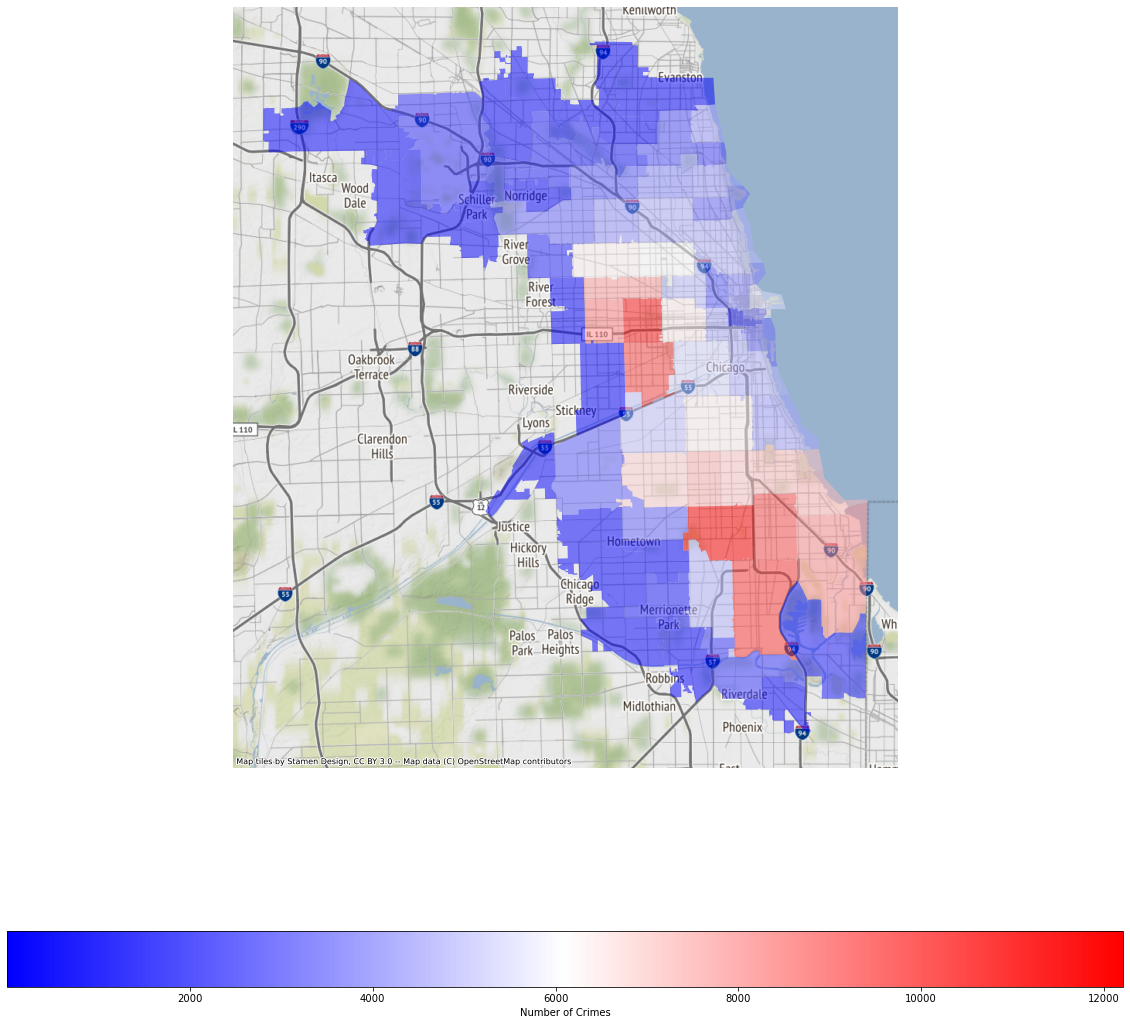

In [5]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(1, 1, figsize=(20,20))
crimes_geo.plot(column='crime_count', ax=ax, legend=True, alpha=0.5, cmap='bwr', legend_kwds={'label': 'Number of Crimes', 'orientation':'horizontal'})
ax.axis('off')
ctx.add_basemap(ax)
plt.show()

The map clearly shows the crime hotspots in the city for 2019 (the areas in red) versus the areas with fewer crimes (the areas in blue).